<a href="https://colab.research.google.com/github/ACM-Research/fraudulent-website-detection/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import our data here
import keras
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf

from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

# Read the data in
df = pd.read_csv("sample2.csv")
url_list = df.url
classif_list = df.type

In [ ]:
y = np.array(list(map(lambda x: 0 if x=="benign" else 1, classif_list)))

X_train, X_test, Y_train, Y_test = train_test_split(url_list, y, test_size = 0.3, random_state = 45)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map

In [ ]:
wMap = read_glove_vector('glove.6B.50d.txt')
maxLen = 250

In [ ]:
vocab_len = len(words_to_index) + 1
embed_vector_len = wMap['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = wMap.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights=[emb_matrix], trainable = False)


In [ ]:
def conv_rating(input_shape):
  X_indices = Input(input_shape)
  embeddings = embedding_layer(X_indices)

  X = Conv1D(512,3,activation='relu')(embeddings)
  X = MaxPooling1D(3)(X)

  X = Conv1D(256,3,activation='relu')(X)
  X = MaxPooling1D(3)(X)

  X = Conv1D(256,3,activation='relu')(X)
  X = Dropout(0.8)(X)

  X = MaxPooling1D(3)(X)
  X = GlobalMaxPooling1D()(X)

  X = Dense(256, activation='relu')(X)
  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model_conv = conv_rating((maxLen,))
model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 50)           544700    
                                                                 
 conv1d (Conv1D)             (None, 248, 512)          77312     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 82, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 256)           393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 26, 256)          0         
 1D)                                                         

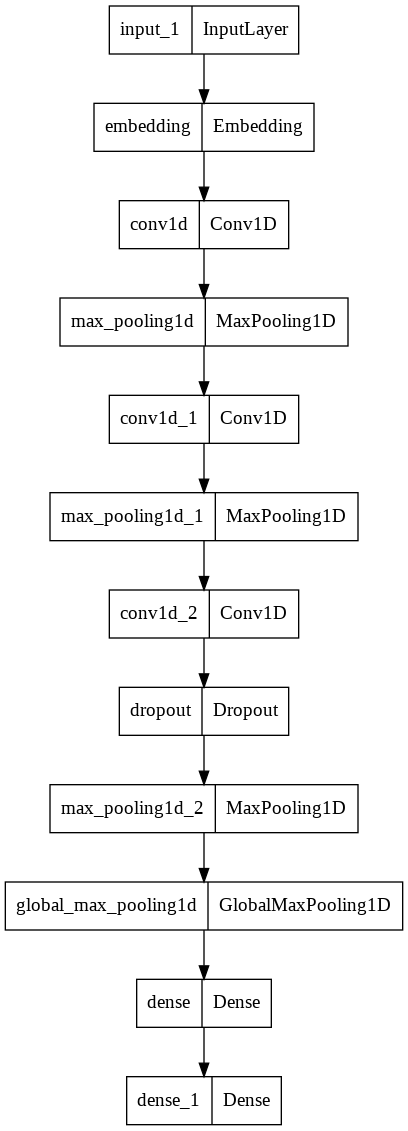

In [ ]:
plot_model(model_conv, to_file='model.png')

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=250, padding='post')
X_train_indices.shape

(3499, 250)

In [ ]:
pd.DataFrame(X_train)

,url
3780,http://techcrunch.com/2015/03/13/this-week-on-...
780,starpacintl.com
1679,allmusic.com/artist/dru-down-p45143
1316,blackle.com/
2695,websenti.u707.jussieu.fr/sentiweb/?rub=37
...,...
4473,icehockey.wikia.com/wiki/2010_IIHF_World_Champ...
580,youtube.com/watch?v=093nXYvngLc
163,http://www.vanoorschotkranen.nl/hoogwerker/hoo...
4703,askbiography.com/bio/Peter_Hansen_(actor).html


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_conv.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model_conv.fit(X_train_indices, Y_train, batch_size=64, epochs=30)

Epoch 1/30
55/55 [==============================] - 29s 510ms/step - loss: 0.5879 - accuracy: 0.7185
Epoch 2/30
55/55 [==============================] - 28s 510ms/step - loss: 0.4043 - accuracy: 0.8260
Epoch 3/30
55/55 [==============================] - 28s 512ms/step - loss: 0.2906 - accuracy: 0.8917
Epoch 4/30
55/55 [==============================] - 28s 511ms/step - loss: 0.2359 - accuracy: 0.9185
Epoch 5/30
55/55 [==============================] - 28s 510ms/step - loss: 0.1870 - accuracy: 0.9308
Epoch 6/30
55/55 [==============================] - 30s 544ms/step - loss: 0.1654 - accuracy: 0.9377
Epoch 7/30
55/55 [==============================] - 28s 513ms/step - loss: 0.1460 - accuracy: 0.9457
Epoch 8/30
55/55 [==============================] - 28s 512ms/step - loss: 0.1370 - accuracy: 0.9474
Epoch 9/30
55/55 [==============================] - 28s 512ms/step - loss: 0.1174 - accuracy: 0.9566
Epoch 10/30
55/55 [==============================] - 28s 513ms/step - loss: 0.1096 - accura

In [ ]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [ ]:
model_conv.evaluate(X_test_indices, Y_test)

47/47 [==============================] - 4s 72ms/step - loss: 0.1687 - accuracy: 0.9487


[0.1687009036540985, 0.9486666917800903]

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print(roc_auc_score(Y_test,model_conv.predict(X_test_indices)))

yy = model_conv.predict(X_test_indices)
#print(yy)
for i in range(yy.size):
  if(yy[i]<.5):
    yy[i]=0
  else:
    yy[i]=1
print(precision_score(Y_test,yy))
print("F1:")
print(f1_score(Y_test,yy))

0.9789074248120301
0.9469026548672567
F1:
0.8929068150208622


In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix

preds = model_conv.predict(X_test_indices)
print("Recall:")
print(recall_score(Y_test, yy))
#print(classification_report(Y_test, model_conv.predict(X_test_indices)))

Recall:
0.8342105263157895


In [ ]:
n = np.random.randint(0,1500)

if preds[n] >= 0.5:
  print('Website is predicted to be: fraudulent')
else: 
  print('Website is predicted to be: NOT fraudulent')

if (Y_test[n] == 1):
  print('The website is: fraudulent')
else:
  print('The website is: NOT fraudulent')

preds[n]

Website is predicted to be: fraudulent
The website is: fraudulent


array([0.999985], dtype=float32)

In [ ]:
url_list_idx = tokenizer.texts_to_sequences(url_list)

In [ ]:
def add_score_predictions(data, url_list_idx):
  url_list_idx = pad_sequences(url_list_idx, maxlen=maxLen, padding='post')
  url_preds = model_conv.predict(url_list_idx)
  data['fraudulent score'] = url_preds
  pred_sentiment = np.array(list(map(lambda x: 'fraudulent' if x > 0.5 else 'not fraudulent', url_preds)))
  data['predicted'] = 0
  data['predicted'] = pred_sentiment
  return data

In [ ]:
data = add_score_predictions(url_list, url_list_idx)

In [ ]:
data

0                                                    br-icloud.com.br
1                                 mp3raid.com/music/krizz_kaliko.html
2                                     bopsecrets.org/rexroth/cr/1.htm
3                   http://www.garage-pirenne.be/index.php?option=...
4                   http://adventure-nicaragua.net/index.php?optio...
                                          ...                        
4996                vividseats.com/ncaab/big-12-tournament-tickets...
4997                http://allegro.pl/listing/listing.php?id=20585...
4998                                        mfhn.com/lalonde/i664.asp
fraudulent score    [[0.98215526], [2.4065741e-06], [0.0026723146]...
predicted           [fraudulent, not fraudulent, not fraudulent, f...
Name: url, Length: 5001, dtype: object

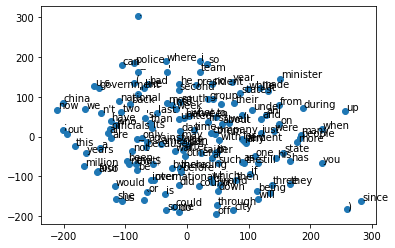

In [ ]:
# # Load the TensorBoard notebook extension.
# %load_ext tensorboard

# from datetime import datetime
# from packaging import version

# import tensorflow as tf
# from tensorflow import keras

# print("TensorFlow version: ", tf.__version__)
# assert version.parse(tf.__version__).release[0] >= 2, \
#     "This notebook requires TensorFlow 2.0 or above."

# import tensorboard
# tensorboard.__version__

# # Clear any logs from previous runs
# !rm -rf ./logs/ 


import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3,perplexity=40, early_exaggeration=80.0, random_state=0)

words =  list(wMap.keys())
vectors = [wMap[word] for word in words]
Y = tsne.fit_transform(vectors[:150])
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
plt.show()